In [37]:
import scipy.io
import keras
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import pandas as pd
import random 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, UpSampling2D
from keras.layers import MaxPooling2D, Flatten, BatchNormalization   

from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline 



In [38]:
df=pd.read_msgpack('/Users/liginsolamen/MRE/MREData/MREdata_072118.msg')

In [39]:
Ur=np.stack(df.Ur.values,axis=3).transpose(3,0,1,2)
Ui=np.stack(df.Ui.values,axis=3).transpose(3,0,1,2)

X=np.sqrt(Ui**2+Ur**2)

Y=np.stack(df.RS.values,axis=2).transpose(2,0,1)
Y=Y.reshape(612,-1)
Y=Y/10000
print(X.shape)
print(Y.shape)

(612, 64, 64, 3)
(612, 4096)


In [40]:
train_X,test_X,train_Y,test_Y=train_test_split(X,Y,test_size=0.3)
train_X,valid_X,train_Y,valid_Y=train_test_split(train_X,train_Y,test_size=0.3)

print(X.shape) #612,64,64,3
print(Y.shape) #612,4096
print(train_X.shape) #(299, 64, 64, 3)
print(valid_X.shape) #(129, 64, 64, 3)
print(test_Y.shape) #(184, 4096)



(612, 64, 64, 3)
(612, 4096)
(299, 64, 64, 3)
(129, 64, 64, 3)
(184, 4096)


In [54]:
#Autoencoder
#Batch Normalization is best after the activation function. 

model=Sequential()

#Convolution
model.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu',
                 input_shape=(X.shape[1],X.shape[2],X.shape[3])))

model.add(Conv2D(50, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu'))

model.add(Conv2D(32, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu'))

model.add(Conv2D(32, kernel_size=(3, 3),padding="same",
                 activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3, 3),padding="same",
                 activation='relu'))
model.add(BatchNormalization(axis=1))

#Deconvolution
# model.add(Conv2D(32, kernel_size=(3, 3),padding='same',
#                  activation='relu'))

model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, kernel_size=(3, 3),padding='same',
                 activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, kernel_size=(3, 3),padding='same',
                 activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1, kernel_size=(3, 3),padding='same',
                 activation='relu'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 50)        28850     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 32)          14432     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 8, 32)          128       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
batch_normalization_17 (Batc (None, 8, 8, 32)          32        
__________

In [55]:
model.compile(loss='mean_squared_error',
              optimizer='adam')

train_Y=train_Y.reshape((train_Y.shape[0],64,64,1))
valid_Y=valid_Y.reshape((valid_Y.shape[0],64,64,1))


history=model.fit(train_X, train_Y,
          epochs=100,
          batch_size=1,
          validation_data=(valid_X, valid_Y))

Train on 299 samples, validate on 129 samples
Epoch 1/100
299/299 [==============================] - 14s 46ms/step - loss: 0.0253 - val_loss: 0.0273
Epoch 2/100
299/299 [==============================] - 12s 40ms/step - loss: 0.0110 - val_loss: 0.0187
Epoch 3/100
299/299 [==============================] - 11s 38ms/step - loss: 0.0094 - val_loss: 0.0188
Epoch 4/100
299/299 [==============================] - 11s 36ms/step - loss: 0.0076 - val_loss: 0.0157
Epoch 5/100
299/299 [==============================] - 8s 25ms/step - loss: 0.0070 - val_loss: 0.0142
Epoch 6/100
299/299 [==============================] - 7s 25ms/step - loss: 0.0064 - val_loss: 0.0162
Epoch 7/100
299/299 [==============================] - 10s 33ms/step - loss: 0.0055 - 

In [56]:
y_predict=model.predict(test_X)
test_Y=test_Y.reshape(test_Y.shape[0],64,64)
print(y_predict.shape)
y_predit2=y_predict.reshape(y_predict.shape[0],64,64)
print(y_predit2.shape)

(184, 64, 64, 1)
(184, 64, 64)


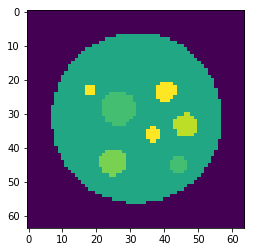

In [73]:
plt.imshow(test_Y[30])

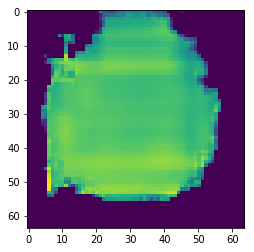

In [74]:
plt.imshow(y_predit2[30])

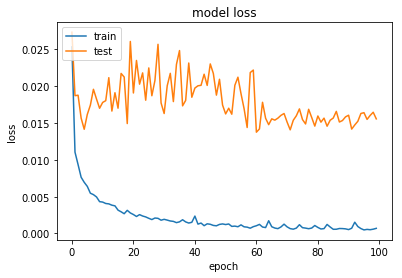

In [75]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
#Test with Contrast Detail Phantom
df_test=pd.read_msgpack('/Users/liginsolamen/MRE/MREData/Test_CDPhantom/Test_CDPhantom.msg')

Ur_test=np.stack(df_test.Ur.values,axis=3).transpose(3,0,1,2)
Ui_test=np.stack(df_test.Ui.values,axis=3).transpose(3,0,1,2)

X_testCD=np.sqrt(Ur_test**2+Ui_test**2)

Y_testCD=np.stack(df_test.RS.values,axis=2).transpose(2,0,1)
print(Y_testCD.shape)

(43, 64, 64)


In [63]:
#Y_testCD=Y_testCD.reshape(43,-1)
Y_testCD=Y_testCD/10000
print(X_testCD.shape)
print(Y_testCD.shape)

y_predict_CD=model.predict(X_testCD)
print(y_predict_CD.shape)

y_predict_CD=y_predict_CD.reshape(y_predict_CD.shape[0],64,64)
print(y_predict_CD.shape)


(43, 64, 64, 3)
(43, 64, 64)
(43, 64, 64, 1)
(43, 64, 64)


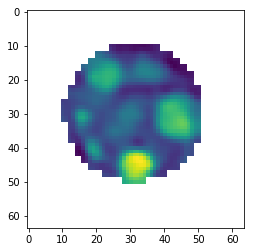

In [64]:
plt.imshow(Y_testCD[13])

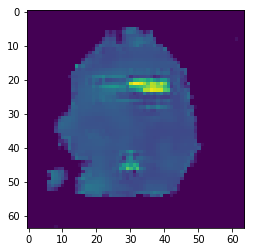

In [65]:
plt.imshow(y_predict_CD[13])